# Kombinere tall fra to tabeller i Statistikkbanken i en tabell og en figur.
## Eksempel Konsumprisindeksen: KPI og KPI-JAE 

Kombinerer data fra Statistikkbanktabellene [03013](https://www.ssb.no/statbank/table/03013) og [05327](https://www.ssb.no/statbank/table/05327)
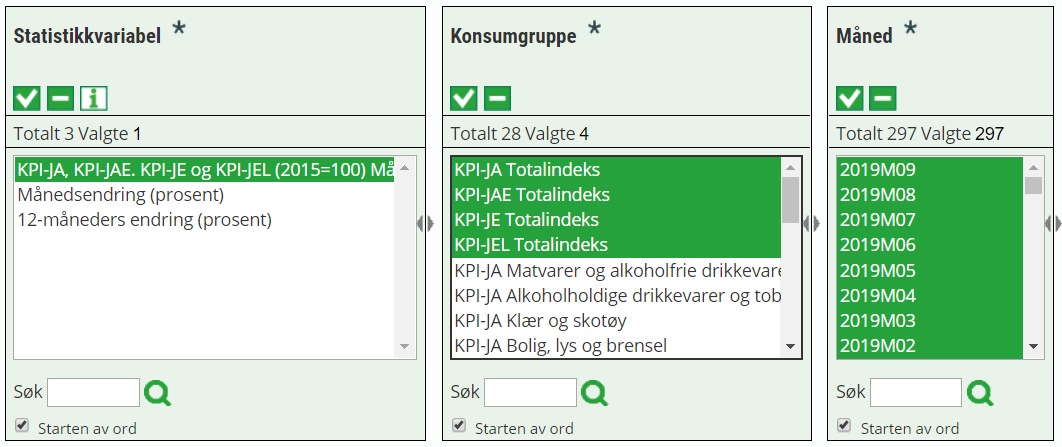

In [1]:
# Her importerer vi ulike pakker
import matplotlib.pyplot as plt
import requests
import pandas as pd
from pyjstat import pyjstat  # pyjstat er for behandling av JSON-stat

 Generell funksjon for å konvertere til datoformat og sette dette som en Pandas PeriodIndex, 
 
 Du kan f.eks. bruke funksjonen på de måndelige tabellene 03013, 05327 og de årlige 03014, 05335.
 Returnerer i tillegg navnet på frekvens-kolonnen

In [2]:

def dateConv(dataframe):
    frekvens, frek_no, frek_en, fmt = findFrequency(dataframe)
    setPeriodIndex(frekvens, frek_no, frek_en, fmt, dataframe)

    #funksjon for for å finne frekvenskolonne    
def findFrequency(dataframe):
    frekvenser = ['måned', 'kvartal', 'uke', 'år', 'year', 'quarter', 'month', 'week']
    frek_no = ''
    freq_en = ''
    fmt = ''
    for w in frekvenser:
        if w in dataframe.columns:
            if w in ['måned', 'month']:
                frek_no = 'M'
                frek_en = 'M'
                fmt = '%YM%m'
            elif w in ['kvartal', 'quarter']:
                frek_no = 'K'
                frek_en = 'Q'
                fmt = '%YK%q'
            elif w in ['uke', 'week']:
                frek_no = 'U';
                frek_en = 'W'
                fmt = '%YW%W-%w'
            else:
                frek_no = ''
                frek_en = 'A'
            return w, frek_no, frek_en, fmt
    
# funksjon for å sette index som PeriodIndex,       
def setPeriodIndex(frekvens, frek_no, freq_en, fmt, df):
    if frekvens in ['kvartal', 'quarter']:
        # erstatter K med Q, konverterr til datoformat og setter frekensen til Pandas PeriodIndex
        df.index = pd.PeriodIndex(pd.to_datetime(df[frekvens].str.replace(frek_no, freq_en), errors='coerce'), freq='Q-DEC')
    elif frekvens in ['uke', 'week']:
        df.index = pd.PeriodIndex(pd.to_datetime(df[frekvens].str.replace(frek_no, freq_en).add('-0'), format= fmt, errors='coerce'), freq='W-MON')
    else:
        df.index =  pd.PeriodIndex(pd.to_datetime(df[frekvens], format= fmt, errors='coerce'), freq=freq_en)
    return frekvens


URL til tabellenes metadata i PxWebApi, som vi skal poste spørringene mot

In [3]:
URL1 = 'https://data.ssb.no/api/v0/no/table/05327' # KPI-jae etc.
URL2 = 'https://data.ssb.no/api/v0/no/table/03013' # KPI Total

API-spørring i JSON mot tabell [05327](https://www.ssb.no/statbank/table/05327), data for siste 8 år (96 måneder).
* KPI-JA - KPI justert for avgiftsendringer
* KPI-JAE - KPI justert for avgiftsendringer og uten energivarer
* KPI-JE - KPI uten energivarer
* KPI-JEL - KPI uten elektrisitet


In [4]:
sp1 = {
  "query": [
    {
      "code": "Konsumgrp",
      "selection": {
        "filter": "item",
        "values": ['JA_TOTAL', 'JAE_TOTAL', 'JE_TOTAL', 'JEL_TOTAL']
      }
    },
    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": ["KPIJustIndMnd"]
      }
    },
    {
      "code": "Tid",
      "selection": {
        "filter": "top",
        "values": [ "96" ]
      }
    }
  ],
  "response": {
    "format": "json-stat2"
  }
}


JSON-spørring mot tabell [03013](https://www.ssb.no/statbank/table/03013) siste 8 år

In [5]:
sp2 = {
  "query": [
    {
      "code": "Konsumgrp",
      "selection": {
        "filter": "item",
        "values": ["TOTAL"]
      }
    },
    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": ["KpiIndMnd"]
      }
    },
    {
      "code": "Tid",
      "selection": {
        "filter": "top",
        "values": ["96"]
      }
    }
  ],
  "response": {
    "format": "json-stat2"
  }
}


Poster spørringene sp1 og sp2 mot metadata url'er. Resultatene lagres som res1 og res2

In [6]:
res1 = requests.post(URL1, json=sp1)
res2 = requests.post(URL2, json=sp2)

Leser resultatet med JSON-stat biblioteket pyjstat

In [7]:
ds1 = pyjstat.Dataset.read(res1.text)
ds2 = pyjstat.Dataset.read(res2.text)

Skriver dette til to Pandas dataframes, df1 og df2.

In [8]:
df1 = ds1.write('dataframe')
df2 = ds2.write('dataframe')

In [9]:
df1.head(7)

,konsumgruppe,statistikkvariabel,måned,value
0,KPI-JA Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2017M01,104.0
1,KPI-JA Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2017M02,104.4
2,KPI-JA Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2017M03,104.8
3,KPI-JA Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2017M04,104.9
4,KPI-JA Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2017M05,105.2
5,KPI-JA Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2017M06,105.6
6,KPI-JA Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2017M07,105.9


In [10]:
df1.tail() # slutten av datasettet

,konsumgruppe,statistikkvariabel,måned,value
379,KPI-JEL Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2024M08,131.0
380,KPI-JEL Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2024M09,131.2
381,KPI-JEL Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2024M10,131.6
382,KPI-JEL Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2024M11,131.8
383,KPI-JEL Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2024M12,131.6


Kaller funksjonen for datokonvertering. *Kan sløyfes*.

In [11]:
dateConv(df1)

In [12]:
df1.index

PeriodIndex(['2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06',
             '2017-07', '2017-08', '2017-09', '2017-10',
             ...
             '2024-03', '2024-04', '2024-05', '2024-06', '2024-07', '2024-08',
             '2024-09', '2024-10', '2024-11', '2024-12'],
            dtype='period[M]', name='måned', length=384)

In [13]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 384 entries, 2017-01 to 2024-12
Freq: M
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   konsumgruppe        384 non-null    object 
 1   statistikkvariabel  384 non-null    object 
 2   måned               384 non-null    object 
 3   value               384 non-null    float64
dtypes: float64(1), object(3)
memory usage: 15.0+ KB


In [14]:
df1.tail(15)

,konsumgruppe,statistikkvariabel,måned,value
måned,,,,
2023-10,KPI-JEL Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2023M10,128.3
2023-11,KPI-JEL Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2023M11,128.1
2023-12,KPI-JEL Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2023M12,128.2
2024-01,KPI-JEL Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2024M01,128.3
2024-02,KPI-JEL Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2024M02,128.9
2024-03,KPI-JEL Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2024M03,129.0
2024-04,KPI-JEL Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2024M04,130.2
2024-05,KPI-JEL Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2024M05,130.7
2024-06,KPI-JEL Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2024M06,131.0


In [15]:
dateConv(df2) # kan sløyfes eller kommenteres ut.

Plot av df2 blir riktig, for her er det bare en serie

<Axes: xlabel='måned'>

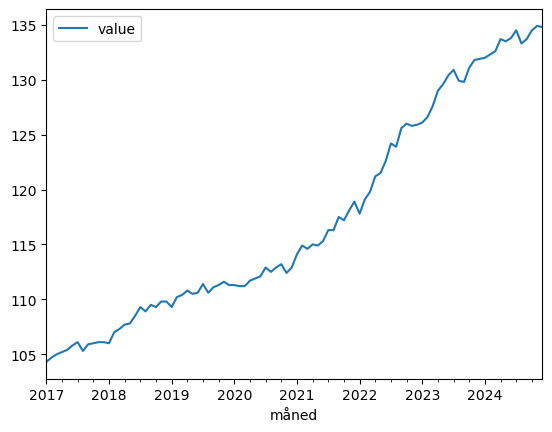

In [16]:
df2.plot()   

Standard plot av df1 gir alle 4 intervallene. Resultat er avhengig av om det er dato eller kategori på x-aksen.

<Axes: xlabel='måned'>

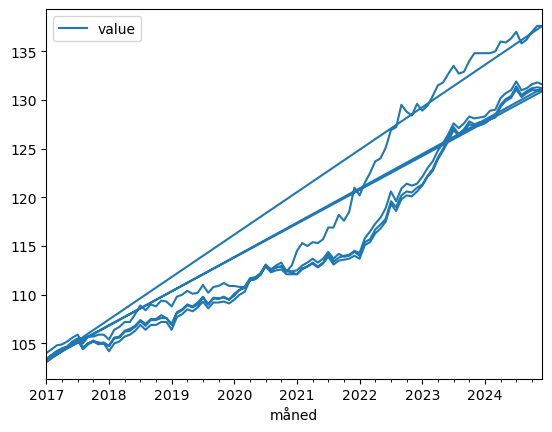

In [17]:
df1.plot() # standard plot gir alle 4 intervallene og resultat er avhengig av om det er dato eller kategori på x-aksen

### slår sammen de to "dataframene"  df1 og df2 med en enkel concat til datasettet "sammen"

In [18]:
sammen = pd.concat([df1,df2])

Viser topp og bunn for det sammeslåtte datasettet

In [19]:
sammen.head()

,konsumgruppe,statistikkvariabel,måned,value
måned,,,,
2017-01,KPI-JA Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2017M01,104.0
2017-02,KPI-JA Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2017M02,104.4
2017-03,KPI-JA Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2017M03,104.8
2017-04,KPI-JA Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2017M04,104.9
2017-05,KPI-JA Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2017M05,105.2


In [20]:
sammen.tail()

,konsumgruppe,statistikkvariabel,måned,value
måned,,,,
2024-08,Totalindeks,Konsumprisindeks (2015=100),2024M08,133.3
2024-09,Totalindeks,Konsumprisindeks (2015=100),2024M09,133.7
2024-10,Totalindeks,Konsumprisindeks (2015=100),2024M10,134.5
2024-11,Totalindeks,Konsumprisindeks (2015=100),2024M11,134.9
2024-12,Totalindeks,Konsumprisindeks (2015=100),2024M12,134.8


Sjekk for fotnoter i datasett ds1 og ds2. Nytt i JSON-stat2.

In [21]:
if 'note' in ds1:
    note = ds1['note']
    print(note)

['KPI-JE=KPI uten energivarer, KPI-JEL=KPI uten elektrisitet, KPI-JA=KPI justert for avgiftsendringer, KPI-JAE=KPI justert for avgiftsendringer og uten energivarer. Tidsseriene for KPI-JE og KPI-JEL går tilbake til 1995 (1998=100), mens tidsseriene for KPI-JA og KPI-JAE går tilbake til 2003 (juli 1999=100). <br><br>\nF.o.m. 2017 er referanseår 2015=100. Endringstall beregnet fra 2015=100 serier kan være ulike fra tidligere publiserte endringstall. Avvikene skyldes i all hovedsak avrundingseffekter. Se den avsluttede tidsserien 11451 for publiserte endringstall t.o.m. 2016 med 1998=100.', 'Enkelte prisindekser for tjenester som inngår i KPI er basert på estimerte verdier fra og med april  2020. Se mer detaljert informasjon i tabell 03013.', 'Seriene KPI-JA Totalindeks og KPI-JA Bolig, lys og brensel ble i august 2023 korrigert for perioden januar 2023 til juni 2023.']


In [22]:
if 'note' in ds2:
    note2 = ds2['note']
    print(note)

['KPI-JE=KPI uten energivarer, KPI-JEL=KPI uten elektrisitet, KPI-JA=KPI justert for avgiftsendringer, KPI-JAE=KPI justert for avgiftsendringer og uten energivarer. Tidsseriene for KPI-JE og KPI-JEL går tilbake til 1995 (1998=100), mens tidsseriene for KPI-JA og KPI-JAE går tilbake til 2003 (juli 1999=100). <br><br>\nF.o.m. 2017 er referanseår 2015=100. Endringstall beregnet fra 2015=100 serier kan være ulike fra tidligere publiserte endringstall. Avvikene skyldes i all hovedsak avrundingseffekter. Se den avsluttede tidsserien 11451 for publiserte endringstall t.o.m. 2016 med 1998=100.', 'Enkelte prisindekser for tjenester som inngår i KPI er basert på estimerte verdier fra og med april  2020. Se mer detaljert informasjon i tabell 03013.', 'Seriene KPI-JA Totalindeks og KPI-JA Bolig, lys og brensel ble i august 2023 korrigert for perioden januar 2023 til juni 2023.']


### Omstrukturerer (pivoterer) tabellen for å få en bedre visning

Se evt. ["Tidy data" av Hadley Wickham](https://vita.had.co.nz/papers/tidy-data.pdf)


In [23]:
df3 = sammen.pivot(columns='konsumgruppe', values='value')

# uten kall til dateconv() bruk måned som index slik
# df3 = sammen.pivot(index='måned', columns='konsumgruppe', values='value')

In [24]:
df3.head(3)

konsumgruppe,KPI-JA Totalindeks,KPI-JAE Totalindeks,KPI-JE Totalindeks,KPI-JEL Totalindeks,Totalindeks
måned,,,,,
2017-01,104.0,103.1,103.3,103.4,104.3
2017-02,104.4,103.6,103.8,103.8,104.7
2017-03,104.8,104.0,104.2,104.2,105.0


In [25]:
df3.index

PeriodIndex(['2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06',
             '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12',
             '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
             '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12',
             '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06',
             '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12',
             '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06',
             '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12',
             '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06',
             '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12',
             '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06',
             '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12',
             '2023-01', '2023-02', '2023-03', '2023-

In [26]:

df3.tail(3)

konsumgruppe,KPI-JA Totalindeks,KPI-JAE Totalindeks,KPI-JE Totalindeks,KPI-JEL Totalindeks,Totalindeks
måned,,,,,
2024-10,137.0,131.2,131.0,131.6,134.5
2024-11,137.6,131.3,131.0,131.8,134.9
2024-12,137.6,131.2,130.9,131.6,134.8


### Figur med Pandas innebygde plot-funksjon 

<Axes: xlabel='måned'>

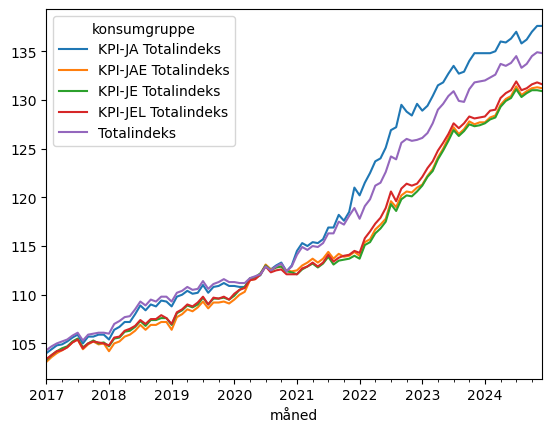

In [27]:
df3.plot()

Plot med flere parametre

<Axes: xlabel='måned'>

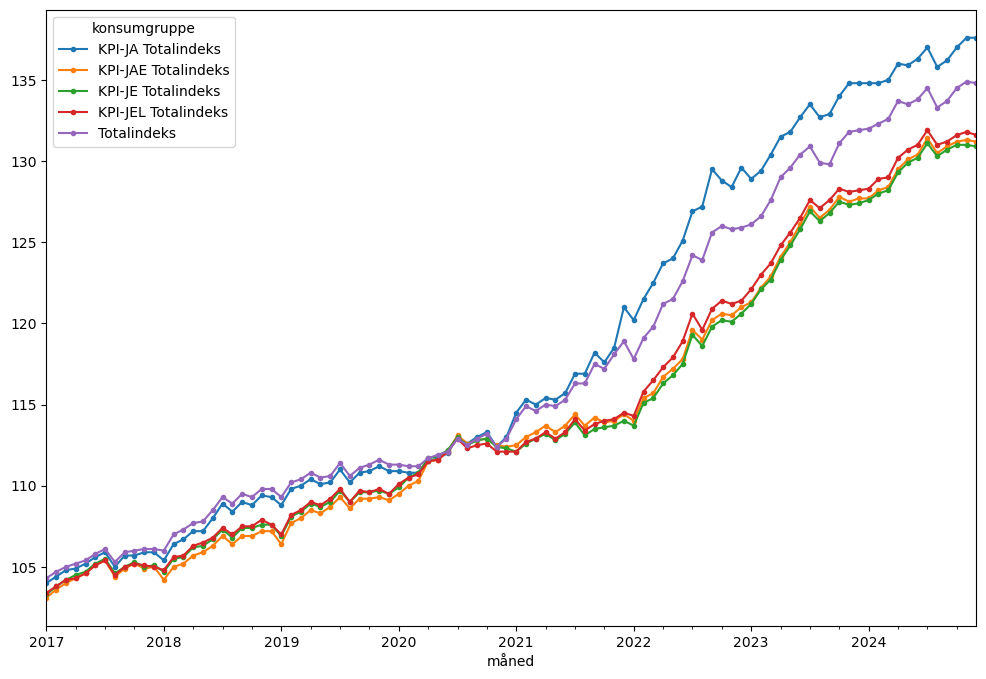

In [28]:
df3.plot(marker="o", markersize=3, figsize=(12, 8))

Lagrer figurvisningen som en funksjon. Her brukes det litt mer fleksible Matplotlib. 
Merk at tittel har dynamisk tid. 
Her er også SSBfarger definert. Du kan gi høyde og bredde som parametre.

In [31]:
def visfigur(bredde=12, hoyde=6):
    fig, ax = plt.subplots(figsize=(bredde, hoyde))  
    #definerer ssb farger på figurene
    ssbCol = ['#1a9d49', '#075745', '#1d9de2', '#0f2080', '#c78800', '#471f00', '#c775a7', '#a3136c', '#909090', '#000000']
    plt.xlabel('måned') 
    plt.ylabel('index')
    ax.set_title('Figur som viser KPI total og undeliggende KPI serier' + ', ' + df1['måned'].iloc[0] + '-' + df1['måned'].iloc[-1])
    df3.plot(ax=ax, color=ssbCol)
    plt.show()

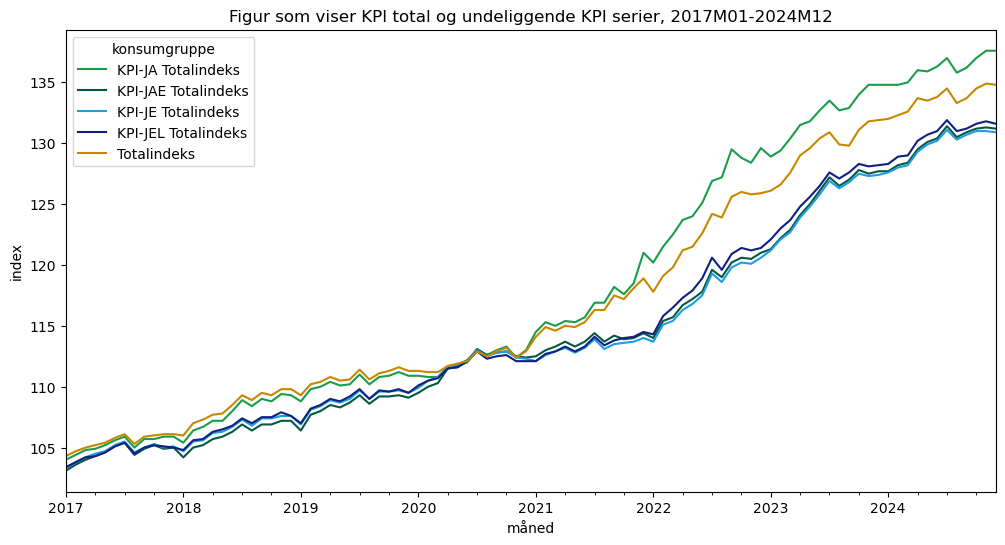

In [32]:
visfigur()

### Plot med ulike stiler
I Matplotlib kan du prøve ut ulike ferdige stiler. Vi kan evt. lage vår egen etter SSBs designmal.

Prøv ut: 'Solarize_Light2',  'bmh', 'classic', 'dark_background' 'fivethirtyeight', 'seaborn-talk'

In [ ]:
with plt.style.context('Solarize_Light2'):
    visfigur()

In [ ]:
with plt.style.context('fivethirtyeight'):
    visfigur(16, 9)